In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, GlobalMaxPooling1D, Input
from keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14018990211953302329
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1097274393279167084
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9486070452481106344
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 788225537063127218
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


We check if the GPU is available

In [3]:
PATH = "data/"

In [4]:
train = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")

We read both the training and testing csv files

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Clearly 'comment_text' is the input to the algorithm and 'toxic', 'severe_toxic', 'obscene' etc are the outputs. Note that they are not mutually exclusive. Hence we can say that this is an example of multi label classification.

In [6]:
train.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [7]:
test.isna().sum()

id              0
comment_text    0
dtype: int64

We need not deal with null values as there are none.

In [8]:
list_categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

We use this list to extract only the dependent variables from the dataset.

In [9]:
train_x = train['comment_text']
train_y = train[list_categories]
test_x = test['comment_text']

We separate the dependent variables from the independent variables.

In [10]:
no_of_features = 20000

The maximum no. of words we want to consider. Can be considered a hyperparameter.

In [11]:
tokenizer = Tokenizer(num_words=no_of_features)

We use a tokenizer to tokenize i.e. break text into tokens. A token can be thought of as an atomic / indivisible string of characters.

In [12]:
tokenizer.fit_on_texts(texts=train_x)

We fit the tokenizer on the training dataset.

In [13]:
tokenized_train_x = tokenizer.texts_to_sequences(train_x)
tokenized_test_x = tokenizer.texts_to_sequences(test_x)

We perform the tokenization process on both the training and testing dataset.

In [14]:
sequence_lengths = [len(sequence) for sequence in tokenized_train_x]

We obtain the lengths of the resultant sequences.

In [15]:
max(sequence_lengths)

1400

The largest sequence length.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


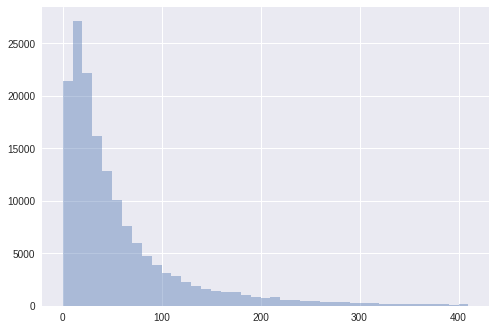

In [16]:
sns.distplot(sequence_lengths, kde=False, bins=np.arange(0, 420, 10))

We plot a histogram of the sequence lengths (frequency vs sequence length). It tells which frequency (maximum length) we can choose.

In [17]:
max_length = 200

Can be considered a hyperparameter.

In [18]:
padded_train_x = pad_sequences(tokenized_train_x, maxlen=max_length)
padded_test_x = pad_sequences(tokenized_test_x, maxlen=max_length)

The algorithm demands that the sequences be of equal length. The resultant sequences of tokens will most likely not be so. Hence we pad them i.e. append them by zeros so that all become equal in length.

In [19]:
padded_train_x.shape

(159571, 200)

In [20]:
padded_test_x.shape

(153164, 200)

In [21]:
inp = Input(shape=(max_length,))

In [22]:
embedding_size = 200
x = Embedding(input_dim=no_of_features, output_dim=embedding_size)(inp)

In [23]:
x = Bidirectional(LSTM(50, return_sequences=True))(x)

In [24]:
x = GlobalMaxPooling1D()(x)

In [25]:
x = Dropout(0.1)(x)

In [26]:
x = Dense(50, activation='relu')(x)

In [27]:
x = Dropout(0.1)(x)

In [28]:
x = Dense(len(list_categories), activation='sigmoid')(x)

This is our actual neural network architecture. We use embeddings, bidirectional LSTMS, max pool layers, dropouts and dense layers.

In [29]:
model = Model(inputs=inp, output=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


We compile our model, using the adam optimizer and binary crossentropy as our loss function.

In [30]:
batch_size = 512
epochs = 2

Can be considered hyperparameters.

In [31]:
model.fit(x=padded_train_x, y=train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/2
127656/127656 [==============================] - 242s 2ms/step - loss: 0.1419 - acc: 0.9629 - val_loss: 0.0540 - val_acc: 0.9808
Epoch 2/2
127656/127656 [==============================] - 239s 2ms/step - loss: 0.0524 - acc: 0.9811 - val_loss: 0.0512 - val_acc: 0.9814


We train the model with a training:validation ratio of 80:20 i.e. 80% of the data will be used for training and the rest will be used for validation.

In [67]:
no_of_examples = 4
lower_limit = np.random.randint(low=0, high=test.shape[0] - no_of_examples)

In [68]:
test_sample = test['comment_text'][lower_limit : lower_limit + no_of_examples - 1]

In [69]:
pd.set_option('display.max_colwidth', -1)
test_sample

42562    The random car placement means that P(C)=1/3 P(G)=2/3.  The random door choice by the host means that these probabilities do not change (in value) when the player makes their choice whether to swap or not.
42563    RUSSELL BRAND IS A CUNT AND SO ARE ALL OF YOU. HAVE FUN.                                                                                                                                                     
42564    " \n\n Stop putting a list of the Ranger Keys on Wikipedia. We got rid of them because the section was getting too big and we did not need it on the article like the list of Decade and Diend cards.—  "    
Name: comment_text, dtype: object

In [70]:
result = np.rint(model.predict(x=padded_test_x[lower_limit : lower_limit + no_of_examples - 1, : ]))

In [71]:
pd.DataFrame(data=result, columns=list_categories)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0


Finally we perform predictions with the test dataset as input.